In [33]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
import numpy as np
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate,train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

In [2]:
dataset=pd.read_excel(r"C:\Users\mahir\Desktop\amazon.xlsx")

In [3]:
dataset.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [4]:
#Tüm harfleri küçük harfe çeviriniz.
dataset['Review']=dataset['Review'].str.lower()

In [5]:
#Noktalama işaretlerini çıkarınız.
dataset['Review']=dataset['Review'].apply(lambda x: re.sub("[^\w\s]","",str(x)))

In [6]:
#Yorumlarda bulunan sayısal ifadeleri çıkarınız.
dataset['Review']=dataset['Review'].apply(lambda x: re.sub("\d","",str(x)))

In [7]:
#Bilgi içermeyen kelimeleri (stopwords) veriden çıkarınız.
sw=stopwords.words('english')
dataset['Review']=dataset['Review'].apply(lambda x:" ".join(x for x in str(x).split() if x not in sw))

In [8]:
#1000'den az geçen kelimeleri veriden çıkarınız.
temp_df=pd.Series(' '.join(dataset["Review"]).split()).value_counts()[-1000:]
dataset["Review"]=dataset["Review"].apply(lambda x:" ".join(x for x in x.split() if x not in temp_df))

In [9]:
#Lemmatization işlemini uygulayınız.
nltk.download('wordnet')
dataset['Review']=dataset["Review"].apply(lambda x:' '.join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mahir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
#"Review" değişkeninin içerdiği kelimelerin frekanslarını hesaplayınız, tf olarak kaydediniz.
tf=dataset["Review"].apply(lambda x:pd.value_counts(x.split(' '))).sum(axis=0).reset_index()
#tf dataframe'inin sütunlarını yeniden adlandırınız: "words", "tf" şeklinde
tf.columns=['words','tf']
tf.sort_values('tf', ascending=False)
tf

,words,tf
0,happy,196.0
1,good,535.0
2,quality,889.0
3,material,565.0
4,however,78.0
...,...,...
5259,relatively,1.0
5260,crispbr,1.0
5261,wfh,1.0
5262,gamers,1.0


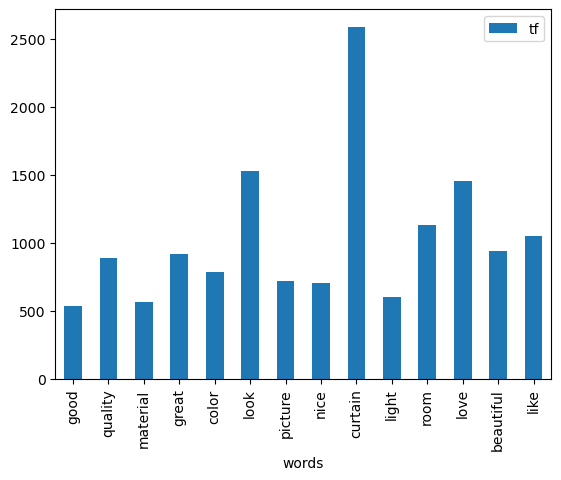

In [12]:
#"tf" değişkeninin değeri 500'den çok olanlara göre filtreleme işlemi yaparak barplot ile görselleştirme işlemini tamamlayınız.
tf[tf['tf']>500].plot.bar(x='words',y='tf')
plt.show()
#BARPLOT

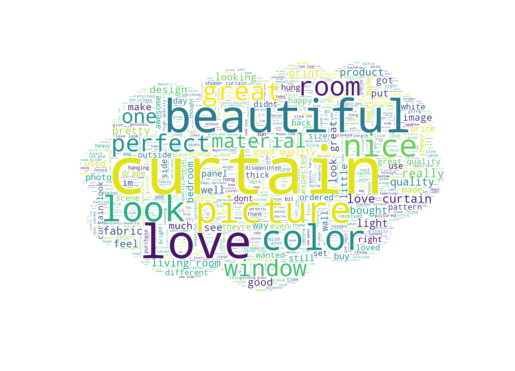

In [17]:
#WORDCLOUD
#"Review" değişkeninin içerdiği tüm kelimeleri "text" isminde string olarak kaydediniz.
text=' '.join(i for i in dataset["Review"])
#WordCloud kullanarak şablon şeklinizi belirleyip kaydediniz.
mask_=np.array(Image.open(r"C:\Users\mahir\Desktop\afa5d11974963a8e6ec4ec2e0724beeb.png"))
#Kaydettiğiniz wordcloud'u ilk adımda oluşturduğunuz string ile generate ediniz.
wordcloud=wordcloud_masked=WordCloud(
    max_words=1000,
    mask=mask_,
    contour_width=0,
    contour_color='black',
    background_color='white'
).generate(text)
#Görselleştirme adımlarını tamamlayınız. (figure, imshow, axis, show)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [18]:
#Python içerisindeki NLTK paketinde tanımlanmış olan SentimentIntensityAnalyzer nesnesini oluşturunuz.
sia=SentimentIntensityAnalyzer()

In [21]:
#"Review" değişkeninin ilk 10 gözlemi için polarity_scores() hesaplayınız.
dataset['Review'][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [22]:
#İncelenen ilk 10 gözlem için compund skorlarına göre filtreleyerek tekrar gözlemleyiniz.
dataset['Review'][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0    0.5719
1    0.4404
2    0.7184
3    0.0000
4    0.9042
5    0.0000
6    0.6249
7    0.9080
8    0.0000
9    0.7096
Name: Review, dtype: float64

In [24]:
#10 gözlem için compound skorları 0'dan büyükse "pos" değilse "neg" şeklinde güncelleyiniz.
dataset["Review"][0:10].apply(lambda x:'pos' if sia.polarity_scores(x)['compound']>0 else 'neg')

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [25]:
#"Review" değişkenindeki tüm gözlemler için pos-neg atamasını yaparak yeni bir değişken olarak dataframe'e ekleyiniz.
dataset["Pos_neg"]=dataset["Review"].apply(lambda x:'pos' if sia.polarity_scores(x)['compound']>0 else 'neg')
dataset

,Star,HelpFul,Title,Review,Pos_neg
0,5,0,looks great,happy,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,pos
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,neg
4,5,0,Wow great purchase,great bang buck cant believe quality material ...,pos
...,...,...,...,...,...
5606,4,0,Recommend,great product reasonable money delivered quick...,pos
5607,5,0,"Terrible , different colors. I returned",color way panel match,neg
5608,5,0,Extremely pleasing,great studio complement entire theme area phot...,pos
5609,5,0,Perfect,brought beauty kid room love,pos


In [26]:
X=dataset['Review']
y=dataset["Pos_neg"]

In [28]:
#Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olarak ayırınız.
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=42)

In [29]:
#TfidfVectorizer kullanarak bir nesne oluşturunuz.
vectorizer=TfidfVectorizer()
#Daha önce ayırmış olduğumuz train datamızı kullanarak oluşturduğumuz nesneye fit ediniz.
vectorizer.fit(X_train)
#Oluşturmuş olduğumuz vektörü train ve test datalarına transform işlemini uygulayıp kaydediniz.
X_train_tfid=vectorizer.transform(X_train)
X_test_tfid=vectorizer.transform(X_test)

In [31]:
#Lojistik regresyon modelini kurarak train dataları ile fit ediniz.
log_model=LogisticRegression()
log_model.fit(X_train_tfid,y_train)

LogisticRegression()

In [32]:
#Predict fonksiyonu ile test datasını tahmin ederek kaydedin
y_test_pred=log_model.predict(X_test_tfid)

In [35]:
#classification_report ile tahmin sonuçlarınızı raporlayıp gözlemleyiniz.
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

         neg       0.90      0.33      0.49       223
         pos       0.89      0.99      0.94      1180

    accuracy                           0.89      1403
   macro avg       0.89      0.66      0.71      1403
weighted avg       0.89      0.89      0.87      1403



In [39]:
print(cross_val_score(log_model, X_test_tfid, y_test, cv=5).mean())

0.8546034570411795


In [54]:
#sample fonksiyonu ile "Review" değişkeni içerisinden örneklem seçerek yeni bir değere atayınız.
random_review=pd.Series(dataset["Review"].sample(1).values)
random_review_=CountVectorizer().fit(X_train).transform(random_review)
sample_pred=log_model.predict(random_review_)
print(f"Review: {random_review[0]} \n Prediction: {sample_pred}")

Review: gorgeous gorgeous gorgeous take entire dining room wall truly breathtaking walk house see across room 
 Prediction: ['pos']


In [55]:
#RandomForestClassifier modelini kurup fit ediniz.
rf_model=RandomForestClassifier().fit(X_train_tfid, y_train)

In [59]:
#Cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız.
print(cross_val_score(rf_model,X_train_tfid, y_train,cv=5, n_jobs=-1).mean())
print(cross_val_score(rf_model,X_test_tfid, y_test,cv=5, n_jobs=-1).mean())

0.9146816509019631
0.8916649720386376
